In [1]:
!pip install -q datasets transformers torch scikit-learn matplotlib seaborn

In [3]:
# Import libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from transformers import BertTokenizer, BertModel
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: Tesla T4
GPU Memory: 15.64 GB


In [6]:
# Set seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [7]:
CONFIG = {
    # Data settings
    'SUBSET_FRACTION': 0.3,       # Use 30% of data (0.3 = fast, 1.0 = full dataset)
    'BALANCE_CLASSES': True,      # Handle class imbalance

    # Model settings
    'MAX_LENGTH': 64,             # Sequence length (64 = fast, 128 = better)
    'BATCH_SIZE': 32,             # Batch size (32 = good balance)
    'FREEZE_BERT': True,          # Freeze BERT base (True = much faster)

    # Training settings
    'LEARNING_RATE': 3e-5,        # Learning rate
    'EPOCHS': 3,                  # Number of epochs
    'DROPOUT': 0.3,               # Dropout rate

    # Optimization
    'USE_MIXED_PRECISION': True,  # Faster training
    'GRADIENT_CLIPPING': 1.0,     # Gradient clipping
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration:
  SUBSET_FRACTION: 0.3
  BALANCE_CLASSES: True
  MAX_LENGTH: 64
  BATCH_SIZE: 32
  FREEZE_BERT: True
  LEARNING_RATE: 3e-05
  EPOCHS: 3
  DROPOUT: 0.3
  USE_MIXED_PRECISION: True
  GRADIENT_CLIPPING: 1.0


# **Load DataSet**

In [8]:
dataset = load_dataset("pietrolesci/pubmed-200k-rct")
print(dataset)

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-12ed98a863dcf4(…):   0%|          | 0.00/204M [00:00<?, ?B/s]

data/validation-00000-of-00001-6f6e21b16(…):   0%|          | 0.00/2.68M [00:00<?, ?B/s]

data/test-00000-of-00001-1d0cf0c8a9ba23d(…):   0%|          | 0.00/2.70M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2211861 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/28932 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/29493 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'text', 'uid'],
        num_rows: 2211861
    })
    validation: Dataset({
        features: ['labels', 'text', 'uid'],
        num_rows: 28932
    })
    test: Dataset({
        features: ['labels', 'text', 'uid'],
        num_rows: 29493
    })
})


In [9]:
report = f"""
Train Samples: {len(dataset['train'])}
Validation Samples: {len(dataset['validation'])}
Test Samples: {len(dataset['test'])}
"""
print(report)


Train Samples: 2211861
Validation Samples: 28932
Test Samples: 29493



In [13]:
train_df = pd.DataFrame({
    'text': dataset['train']['text'],
    'label': dataset['train']['labels']
})

val_df = pd.DataFrame({
    'text': dataset['validation']['text'],
    'label': dataset['validation']['labels']
})

test_df = pd.DataFrame({
    'text': dataset['test']['text'],
    'label': dataset['test']['labels']
})

In [14]:
# Use subset of data for faster training
if CONFIG['SUBSET_FRACTION'] < 1.0:
    print(f"\nUsing {CONFIG['SUBSET_FRACTION']*100}% of training data...")
    train_df = train_df.sample(
        frac=CONFIG['SUBSET_FRACTION'],
        random_state=42
    ).reset_index(drop=True)

    # Also reduce validation/test for faster evaluation
    val_df = val_df.sample(frac=0.5, random_state=42).reset_index(drop=True)
    test_df = test_df.sample(frac=0.5, random_state=42).reset_index(drop=True)

    print(f"  New train size: {len(train_df):,}")
    print(f"  New val size: {len(val_df):,}")
    print(f"  New test size: {len(test_df):,}")


Using 30.0% of training data...
  New train size: 663,558
  New val size: 14,466
  New test size: 14,746


# **EDA**

In [16]:
# Class names
label_names = ['BACKGROUND', 'CONCLUSIONS', 'METHODS','OBJECTIVE', 'RESULTS']

# Count distribution BEFORE balancing
original_counts = train_df['label'].value_counts().sort_index()

print("\nOriginal Class Distribution (before balancing):")
print("="*60)
for i, name in enumerate(label_names):
    count = original_counts[i]
    percentage = (count / len(train_df)) * 100
    print(f"{name:12s}: {count:6,} ({percentage:5.2f}%)")

# Calculate imbalance ratio
max_count = original_counts.max()
min_count = original_counts.min()
imbalance_ratio = max_count / min_count
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 2:
    print("Significant class imbalance detected!")
else:
    print("Classes are relatively balanced")


Original Class Distribution (before balancing):
BACKGROUND  : 58,948 ( 8.88%)
CONCLUSIONS : 101,859 (15.35%)
METHODS     : 216,517 (32.63%)
OBJECTIVE   : 56,193 ( 8.47%)
RESULTS     : 230,041 (34.67%)

Imbalance Ratio: 4.09:1
Significant class imbalance detected!


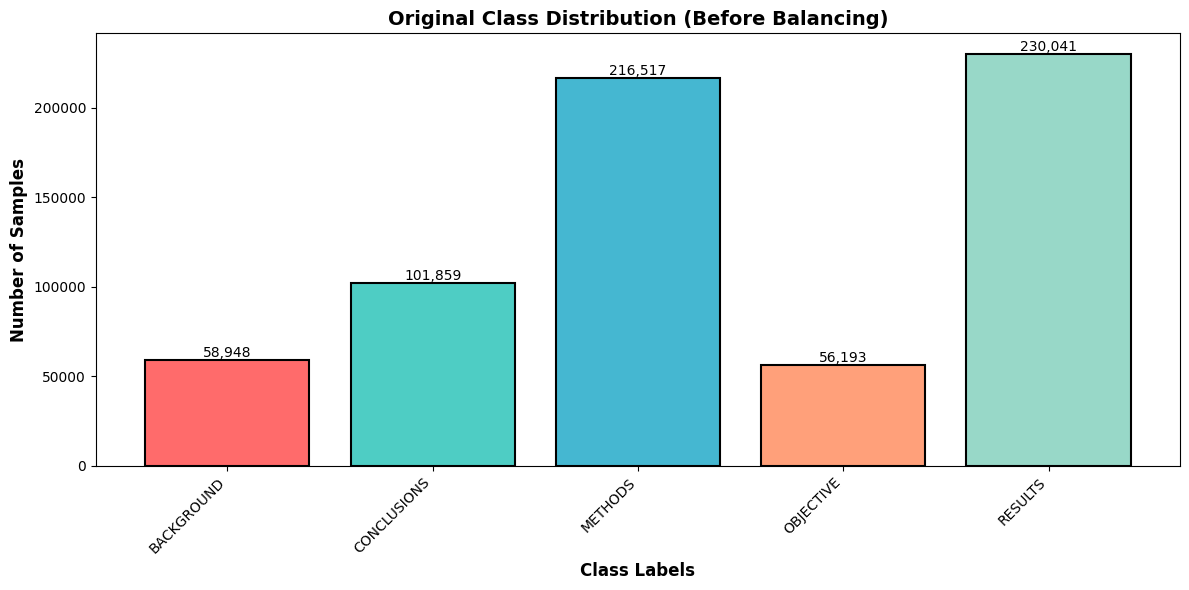

In [17]:
# Plot original distribution
plt.figure(figsize=(12, 6))
bars = plt.bar(
    label_names,
    original_counts.values,
    color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8'],
    edgecolor='black',
    linewidth=1.5
)

plt.xlabel('Class Labels', fontsize=12, fontweight='bold')
plt.ylabel('Number of Samples', fontsize=12, fontweight='bold')
plt.title('Original Class Distribution (Before Balancing)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')

# Add count labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [18]:
# Balance classes using undersampling
if CONFIG['BALANCE_CLASSES']:
    print("\nBalancing classes using undersampling...")

    # Find minimum class size
    min_class_size = train_df['label'].value_counts().min()
    print(f"  Target samples per class: {min_class_size:,}")

    # Undersample each class to minimum size
    balanced_dfs = []
    for label in range(5):
        class_df = train_df[train_df['label'] == label]

        # Undersample to min_class_size
        undersampled = resample(
            class_df,
            replace=False,
            n_samples=min_class_size,
            random_state=42
        )
        balanced_dfs.append(undersampled)

    # Combine and shuffle
    train_df = pd.concat(balanced_dfs, ignore_index=True)
    train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"  Balanced training size: {len(train_df):,}")

    # Show new distribution
    new_counts = train_df['label'].value_counts().sort_index()
    print("\nNew Class Distribution (after balancing):")
    print("="*60)
    for i, name in enumerate(label_names):
        count = new_counts[i]
        percentage = (count / len(train_df)) * 100
        print(f"{name:12s}: {count:6,} ({percentage:5.2f}%)")

    print("\nClasses balanced successfully!")
else:
    print("\nSkipping class balancing (CONFIG['BALANCE_CLASSES'] = False)")


Balancing classes using undersampling...
  Target samples per class: 56,193
  Balanced training size: 280,965

New Class Distribution (after balancing):
BACKGROUND  : 56,193 (20.00%)
CONCLUSIONS : 56,193 (20.00%)
METHODS     : 56,193 (20.00%)
OBJECTIVE   : 56,193 (20.00%)
RESULTS     : 56,193 (20.00%)

✓ Classes balanced successfully!


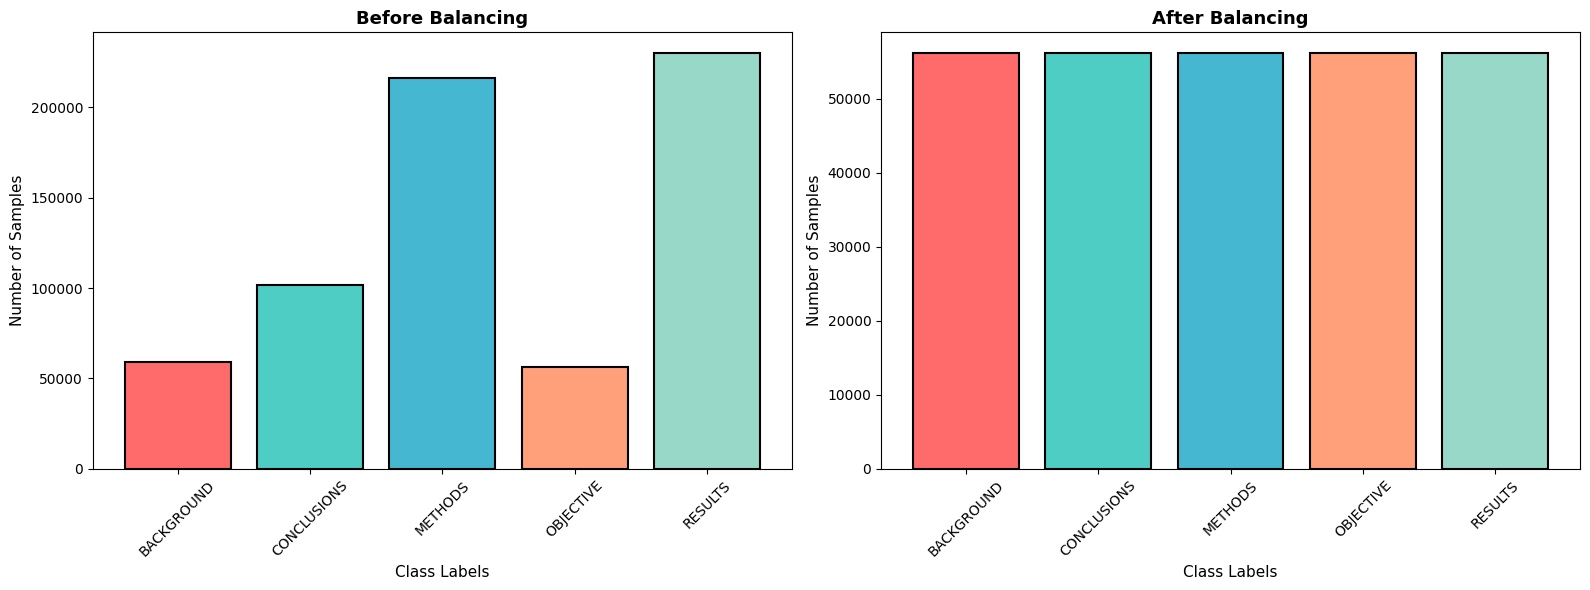

In [19]:
# Plot balanced distribution
if CONFIG['BALANCE_CLASSES']:
    balanced_counts = train_df['label'].value_counts().sort_index()

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Original distribution
    axes[0].bar(label_names, original_counts.values,
                color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8'],
                edgecolor='black', linewidth=1.5)
    axes[0].set_title('Before Balancing', fontsize=13, fontweight='bold')
    axes[0].set_xlabel('Class Labels', fontsize=11)
    axes[0].set_ylabel('Number of Samples', fontsize=11)
    axes[0].tick_params(axis='x', rotation=45)

    # Balanced distribution
    axes[1].bar(label_names, balanced_counts.values,
                color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8'],
                edgecolor='black', linewidth=1.5)
    axes[1].set_title('After Balancing', fontsize=13, fontweight='bold')
    axes[1].set_xlabel('Class Labels', fontsize=11)
    axes[1].set_ylabel('Number of Samples', fontsize=11)
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

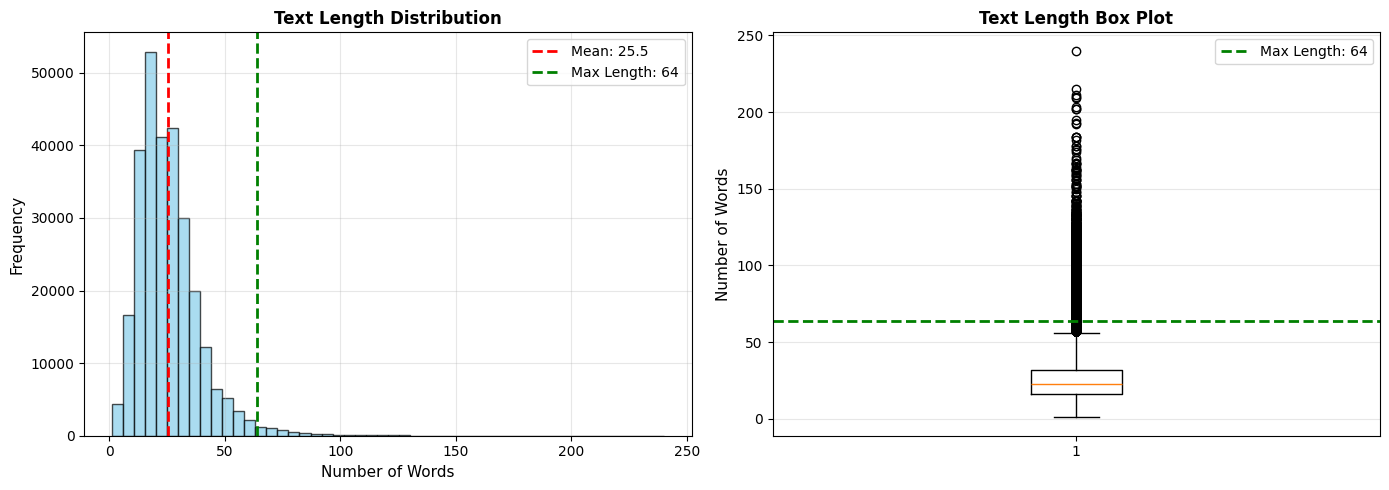


Text Length Statistics:
  Mean: 25.52 words
  Median: 23.00 words
  Max: 240 words
  Min: 1 words
  95th percentile: 50.00 words

1.6% of texts will be truncated at MAX_LENGTH=64


In [20]:
# Analyze text lengths
text_lengths = [len(text.split()) for text in train_df['text']]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(text_lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(np.mean(text_lengths), color='red', linestyle='--',
                linewidth=2, label=f'Mean: {np.mean(text_lengths):.1f}')
axes[0].axvline(CONFIG['MAX_LENGTH'], color='green', linestyle='--',
                linewidth=2, label=f'Max Length: {CONFIG["MAX_LENGTH"]}')
axes[0].set_xlabel('Number of Words', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Text Length Distribution', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(text_lengths, vert=True)
axes[1].axhline(CONFIG['MAX_LENGTH'], color='green', linestyle='--',
                linewidth=2, label=f'Max Length: {CONFIG["MAX_LENGTH"]}')
axes[1].set_ylabel('Number of Words', fontsize=11)
axes[1].set_title('Text Length Box Plot', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nText Length Statistics:")
print(f"  Mean: {np.mean(text_lengths):.2f} words")
print(f"  Median: {np.median(text_lengths):.2f} words")
print(f"  Max: {max(text_lengths)} words")
print(f"  Min: {min(text_lengths)} words")
print(f"  95th percentile: {np.percentile(text_lengths, 95):.2f} words")

truncated_pct = (np.array(text_lengths) > CONFIG['MAX_LENGTH']).mean() * 100
print(f"\n{truncated_pct:.1f}% of texts will be truncated at MAX_LENGTH={CONFIG['MAX_LENGTH']}")

# Custom BERT Classifier

In [52]:
class BERTClassifier(nn.Module):
    """
    BERT model for sequence classification.
    Optimized for speed and performance.
    """

    def __init__(self, num_classes=5, dropout=0.3):
        super(BERTClassifier, self).__init__()

        print("Loading BERT model...")
        # Load pre-trained BERT
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        print("✓ BERT model loaded")

        # Dropout layer (MUST be nn.Dropout, not a float!)
        self.dropout = nn.Dropout(p=dropout)  # ← Fixed: added nn.Dropout()

        # Classification head
        self.fc = nn.Linear(768, num_classes)

        print("✓ Classifier initialized")

    def forward(self, input_ids, attention_mask):
        """Forward pass"""
        # Get BERT outputs
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Use pooled output (CLS token)
        pooled_output = outputs.pooler_output

        # Apply dropout
        pooled_output = self.dropout(pooled_output)

        # Classification
        logits = self.fc(pooled_output)

        return logits

# Custom Dataset Class

In [53]:
class PubMedDataset(Dataset):
    """Custom PyTorch Dataset for PubMed abstracts"""

    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Use __call__ instead of encode_plus (updated API)
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [54]:
# Initialize tokenizer
print("Loading BERT tokenizer...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create datasets
print("Creating PyTorch datasets...")
train_dataset = PubMedDataset(
    texts=train_df['text'].values,
    labels=train_df['label'].values,
    tokenizer=tokenizer,
    max_length=CONFIG['MAX_LENGTH']
)

val_dataset = PubMedDataset(
    texts=val_df['text'].values,
    labels=val_df['label'].values,
    tokenizer=tokenizer,
    max_length=CONFIG['MAX_LENGTH']
)

test_dataset = PubMedDataset(
    texts=test_df['text'].values,
    labels=test_df['label'].values,
    tokenizer=tokenizer,
    max_length=CONFIG['MAX_LENGTH']
)

print(f"\nDataset sizes:")
print(f"  Train: {len(train_dataset):,} samples")
print(f"  Val: {len(val_dataset):,} samples")
print(f"  Test: {len(test_dataset):,} samples")

Loading BERT tokenizer...
Creating PyTorch datasets...

Dataset sizes:
  Train: 280,965 samples
  Val: 14,466 samples
  Test: 14,746 samples


In [55]:
# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['BATCH_SIZE'],
    shuffle=True,
    num_workers=2,
    pin_memory=True  # Faster data transfer to GPU
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['BATCH_SIZE'],
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['BATCH_SIZE'],
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"DataLoader batches:")
print(f"  Train: {len(train_loader)} batches")
print(f"  Val: {len(val_loader)} batches")
print(f"  Test: {len(test_loader)} batches")

# Estimate training time
steps_per_epoch = len(train_loader)
total_steps = steps_per_epoch * CONFIG['EPOCHS']
print(f"\nTraining steps:")
print(f"  Steps per epoch: {steps_per_epoch}")
print(f"  Total steps: {total_steps}")

DataLoader batches:
  Train: 8781 batches
  Val: 453 batches
  Test: 461 batches

Training steps:
  Steps per epoch: 8781
  Total steps: 26343


# Model Setup

In [56]:
# Initializing Model
model = BERTClassifier(num_classes=5, dropout=CONFIG['DROPOUT'])
model = model.to(device)
if CONFIG['FREEZE_BERT']:
  for param in model.bert.parameters():
    param.requires_grad = False
    print("BERT Layers Frozen")
else:
  print("Training All BERT Layers")

Loading BERT model...


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✓ BERT model loaded
✓ Classifier initialized
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT Layers Frozen
BERT 

In [57]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel parameters:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")
print(f"  Frozen: {total_params - trainable_params:,}")
print(f"  Reduction: {(1 - trainable_params/total_params)*100:.1f}% fewer trainable params")


Model parameters:
  Total: 109,486,085
  Trainable: 3,845
  Frozen: 109,482,240
  Reduction: 100.0% fewer trainable params


## Loss and Optimizer:

In [58]:
# Calculate class weights for imbalanced data
print("\nCalculating class weights...")
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label'].values),
    y=train_df['label'].values
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print("Class weights:")
for i, name in enumerate(label_names):
    print(f"  {name:12s}: {class_weights[i]:.4f}")

# Loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer (only optimize trainable parameters)
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=CONFIG['LEARNING_RATE'],
    eps=1e-8
)

print(f"\n✓ Optimizer: AdamW")
print(f"✓ Learning Rate: {CONFIG['LEARNING_RATE']}")
print(f"✓ Loss: Weighted CrossEntropyLoss")


Calculating class weights...
Class weights:
  BACKGROUND  : 1.0000
  CONCLUSIONS : 1.0000
  METHODS     : 1.0000
  OBJECTIVE   : 1.0000
  RESULTS     : 1.0000

✓ Optimizer: AdamW
✓ Learning Rate: 3e-05
✓ Loss: Weighted CrossEntropyLoss


In [59]:
def train_model(model, train_loader, criterion, optimizer, device, scaler, use_amp=True):
    """
    Train model for one epoch with optional mixed precision.
    """
    model.train()

    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    progress_bar = tqdm(train_loader, desc="Training", leave=True)

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        if use_amp:
            # Mixed precision forward pass
            with autocast():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs, labels)

            # Mixed precision backward pass
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=CONFIG['GRADIENT_CLIPPING'])
            scaler.step(optimizer)
            scaler.update()
        else:
            # Standard forward/backward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=CONFIG['GRADIENT_CLIPPING'])
            optimizer.step()

        # Calculate metrics
        _, predictions = torch.max(outputs, dim=1)
        correct_predictions += torch.sum(predictions == labels).item()
        total_samples += labels.size(0)
        total_loss += loss.item()

        # Update progress bar
        current_acc = correct_predictions / total_samples
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{current_acc:.4f}'
        })

    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples

    return avg_loss, accuracy

In [60]:
def evaluate_model(model, data_loader, criterion, device):
    """Evaluate model on validation/test set"""
    model.eval()

    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_predictions = []
    all_labels = []

    progress_bar = tqdm(data_loader, desc="Evaluating", leave=True)

    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)

            # Get predictions
            _, predictions = torch.max(outputs, dim=1)

            # Store results
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Calculate metrics
            correct_predictions += torch.sum(predictions == labels).item()
            total_samples += labels.size(0)
            total_loss += loss.item()

            # Update progress
            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{correct_predictions/total_samples:.4f}'
            })

    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_samples

    return avg_loss, accuracy, all_predictions, all_labels

In [61]:
from torch.cuda.amp import GradScaler

scaler = GradScaler()

In [62]:
import time

print("="*70)
print("STARTING TRAINING")
print("="*70)
print(f"Device: {device}")
print(f"Epochs: {CONFIG['EPOCHS']}")
print(f"Batch Size: {CONFIG['BATCH_SIZE']}")
print(f"Learning Rate: {CONFIG['LEARNING_RATE']}")
print(f"Mixed Precision: {CONFIG['USE_MIXED_PRECISION']}")
print("="*70)

# Storage for metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_accuracy = 0
best_model_state = None

# Start timer
start_time = time.time()

for epoch in range(CONFIG['EPOCHS']):
    epoch_start = time.time()

    print(f"\n{'='*70}")
    print(f"Epoch {epoch + 1}/{CONFIG['EPOCHS']}")
    print(f"{'='*70}")

    # Train
    train_loss, train_acc = train_model(
        model, train_loader, criterion, optimizer, device, scaler,
        use_amp=CONFIG['USE_MIXED_PRECISION']
    )
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validate
    val_loss, val_acc, _, _ = evaluate_model(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    epoch_time = time.time() - epoch_start

    # Print epoch summary
    print(f"\nEpoch {epoch + 1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"  Time: {epoch_time:.2f}s")

    # Save best model
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_model_state = model.state_dict().copy()
        print(f"  ✓ New best model! (Val Acc: {val_acc:.4f})")

    # Estimate remaining time
    if epoch < CONFIG['EPOCHS'] - 1:
        remaining_epochs = CONFIG['EPOCHS'] - epoch - 1
        estimated_time = epoch_time * remaining_epochs
        print(f"  Estimated time remaining: {estimated_time/60:.1f} minutes")

# Load best model
model.load_state_dict(best_model_state)

# Total training time
total_time = time.time() - start_time

print(f"\n{'='*70}")
print("TRAINING COMPLETED!")
print(f"{'='*70}")
print(f"Total training time: {total_time/60:.2f} minutes")
print(f"Best validation accuracy: {best_val_accuracy:.4f}")
print(f"Average time per epoch: {total_time/CONFIG['EPOCHS']:.2f}s")
print(f"{'='*70}")

STARTING TRAINING
Device: cuda
Epochs: 3
Batch Size: 32
Learning Rate: 3e-05
Mixed Precision: True

Epoch 1/3


Evaluating: 100%|██████████| 453/453 [00:53<00:00,  8.49it/s, loss=1.4695, acc=0.6000]



Epoch 1 Summary:
  Train Loss: 1.3646 | Train Acc: 0.4413
  Val Loss:   1.1855 | Val Acc:   0.6000
  Time: 342.50s
  ✓ New best model! (Val Acc: 0.6000)
  Estimated time remaining: 11.4 minutes

Epoch 2/3


Evaluating: 100%|██████████| 453/453 [00:53<00:00,  8.52it/s, loss=1.3362, acc=0.6634]



Epoch 2 Summary:
  Train Loss: 1.1647 | Train Acc: 0.5543
  Val Loss:   1.0247 | Val Acc:   0.6634
  Time: 352.58s
  ✓ New best model! (Val Acc: 0.6634)
  Estimated time remaining: 5.9 minutes

Epoch 3/3


Evaluating: 100%|██████████| 453/453 [00:51<00:00,  8.76it/s, loss=1.2627, acc=0.6851]


Epoch 3 Summary:
  Train Loss: 1.0904 | Train Acc: 0.5804
  Val Loss:   0.9454 | Val Acc:   0.6851
  Time: 343.85s
  ✓ New best model! (Val Acc: 0.6851)

TRAINING COMPLETED!
Total training time: 17.32 minutes
Best validation accuracy: 0.6851
Average time per epoch: 346.32s


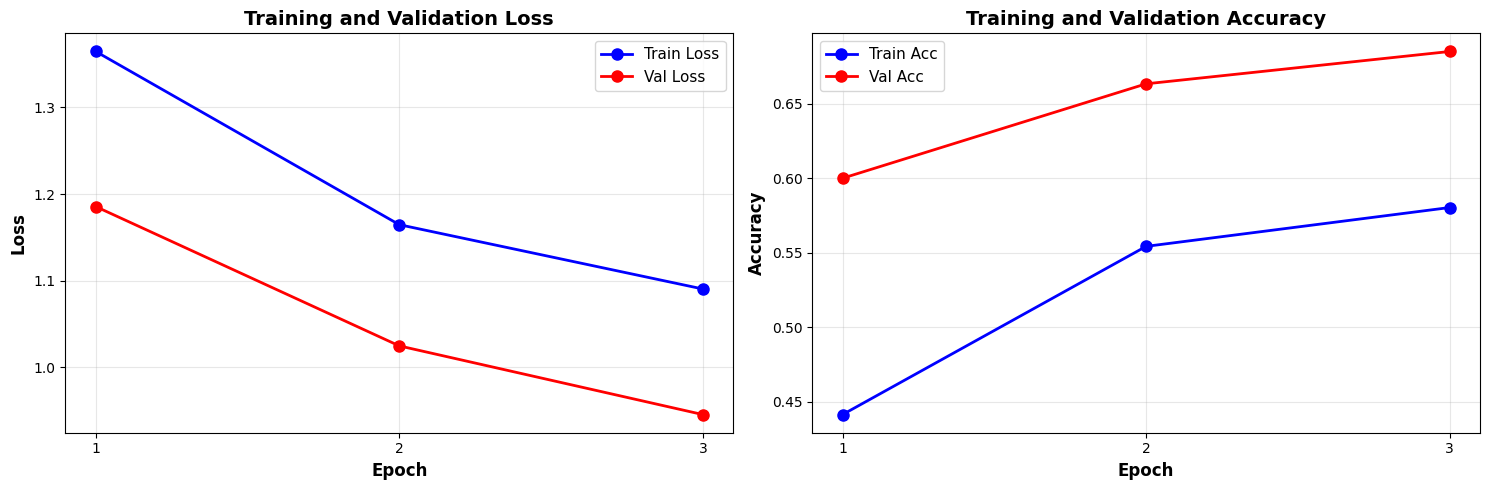


Training Summary:
------------------------------------------------------------
Epoch    Train Loss   Train Acc    Val Loss     Val Acc     
------------------------------------------------------------
1        1.3646       0.4413       1.1855       0.6000      
2        1.1647       0.5543       1.0247       0.6634      
3        1.0904       0.5804       0.9454       0.6851      
------------------------------------------------------------


In [63]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

epochs_range = range(1, CONFIG['EPOCHS'] + 1)

# Loss plot
axes[0].plot(epochs_range, train_losses, 'bo-', label='Train Loss', linewidth=2, markersize=8)
axes[0].plot(epochs_range, val_losses, 'ro-', label='Val Loss', linewidth=2, markersize=8)
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(epochs_range)

# Accuracy plot
axes[1].plot(epochs_range, train_accuracies, 'bo-', label='Train Acc', linewidth=2, markersize=8)
axes[1].plot(epochs_range, val_accuracies, 'ro-', label='Val Acc', linewidth=2, markersize=8)
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(epochs_range)

plt.tight_layout()
plt.show()

# Print summary table
print("\nTraining Summary:")
print("-" * 60)
print(f"{'Epoch':<8} {'Train Loss':<12} {'Train Acc':<12} {'Val Loss':<12} {'Val Acc':<12}")
print("-" * 60)
for i in range(CONFIG['EPOCHS']):
    print(f"{i+1:<8} {train_losses[i]:<12.4f} {train_accuracies[i]:<12.4f} "
          f"{val_losses[i]:<12.4f} {val_accuracies[i]:<12.4f}")
print("-" * 60)

In [64]:
print("\n" + "="*70)
print("EVALUATING ON TEST SET")
print("="*70)

# Evaluate
test_loss, test_acc, test_predictions, test_labels = evaluate_model(
    model, test_loader, criterion, device
)

print(f"\nTest Set Results:")
print(f"  Loss: {test_loss:.4f}")
print(f"  Accuracy: {test_acc:.4f}")


EVALUATING ON TEST SET


Evaluating: 100%|██████████| 461/461 [00:52<00:00,  8.71it/s, loss=1.1634, acc=0.6808]


Test Set Results:
  Loss: 0.9482
  Accuracy: 0.6808


In [65]:
# Calculate all metrics
precision, recall, f1, support = precision_recall_fscore_support(
    test_labels,
    test_predictions,
    average='weighted'
)

print("\n" + "="*70)
print("FINAL EVALUATION METRICS (TEST SET)")
print("="*70)
print(f"Accuracy:  {test_acc:.4f}")
print(f"Precision: {precision:.4f} (weighted)")
print(f"Recall:    {recall:.4f} (weighted)")
print(f"F1-Score:  {f1:.4f} (weighted)")
print("="*70)


FINAL EVALUATION METRICS (TEST SET)
Accuracy:  0.6808
Precision: 0.7002 (weighted)
Recall:    0.6808 (weighted)
F1-Score:  0.6863 (weighted)


In [68]:
# Detailed per-class metrics
print("\nDetailed Classification Report:")
print("="*70)
report = classification_report(
    test_labels,
    test_predictions,
    target_names=label_names,
    digits=4
)
print(report)


Detailed Classification Report:
              precision    recall  f1-score   support

  BACKGROUND     0.4243    0.5873    0.4926      1340
 CONCLUSIONS     0.5986    0.5106    0.5511      2217
     METHODS     0.7422    0.7584    0.7502      4893
   OBJECTIVE     0.4762    0.6395    0.5459      1190
     RESULTS     0.8287    0.7145    0.7674      5106

    accuracy                         0.6808     14746
   macro avg     0.6140    0.6421    0.6215     14746
weighted avg     0.7002    0.6808    0.6863     14746



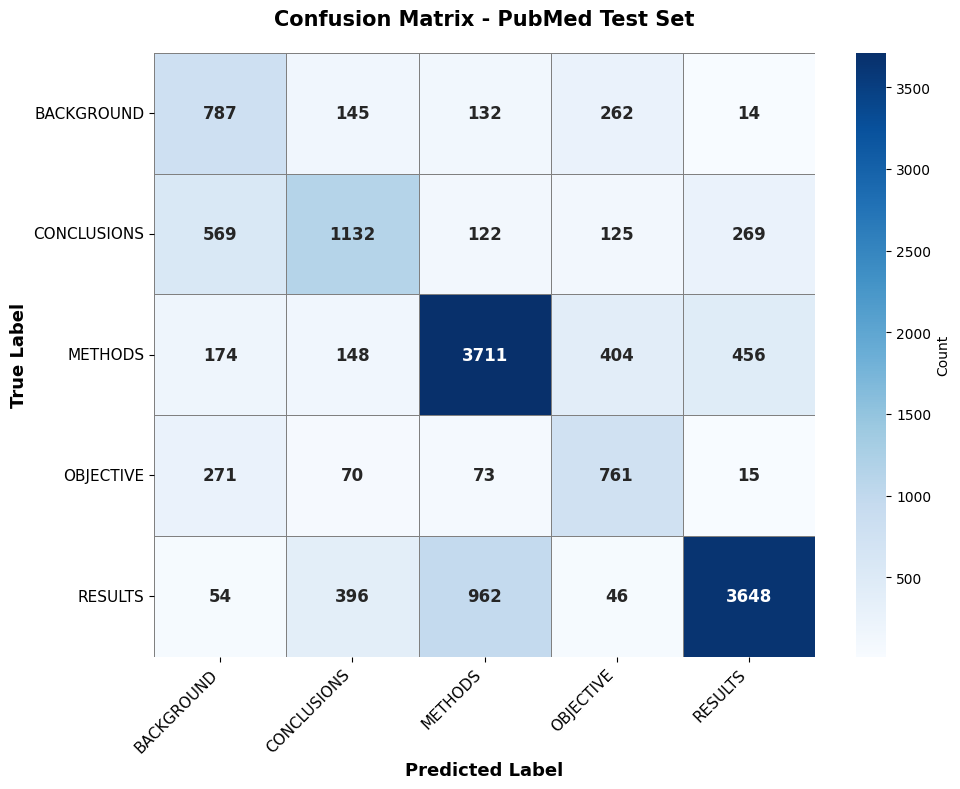


Confusion Matrix Analysis:
------------------------------------------------------------
BACKGROUND  :  787/1340 correct (58.73%) |  553 errors
CONCLUSIONS : 1132/2217 correct (51.06%) | 1085 errors
METHODS     : 3711/4893 correct (75.84%) | 1182 errors
OBJECTIVE   :  761/1190 correct (63.95%) |  429 errors
RESULTS     : 3648/5106 correct (71.45%) | 1458 errors
------------------------------------------------------------


In [66]:
# Create and plot confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_names,
    yticklabels=label_names,
    cbar_kws={'label': 'Count'},
    linewidths=0.5,
    linecolor='gray',
    annot_kws={'size': 12, 'weight': 'bold'}
)
plt.xlabel('Predicted Label', fontsize=13, fontweight='bold')
plt.ylabel('True Label', fontsize=13, fontweight='bold')
plt.title('Confusion Matrix - PubMed Test Set', fontsize=15, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(rotation=0, fontsize=11)
plt.tight_layout()
plt.show()

# Analyze confusion matrix
print("\nConfusion Matrix Analysis:")
print("-" * 60)
for i, label in enumerate(label_names):
    correct = cm[i, i]
    total = cm[i].sum()
    accuracy = correct / total if total > 0 else 0
    errors = total - correct
    print(f"{label:12s}: {correct:4d}/{total:4d} correct ({accuracy:6.2%}) | {errors:4d} errors")
print("-" * 60)

## ScratchPad

In [ ]:
import os
import time

# Create checkpoint directory
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

print("="*70)
print("STARTING TRAINING WITH CHECKPOINTING")
print("="*70)
print(f"Device: {device}")
print(f"Epochs: {CONFIG['EPOCHS']}")
print(f"Checkpoint directory: {checkpoint_dir}")
print("="*70)

# Storage for metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_accuracy = 0
best_model_state = None

# Start timer
start_time = time.time()

for epoch in range(CONFIG['EPOCHS']):
    epoch_start = time.time()

    print(f"\n{'='*70}")
    print(f"Epoch {epoch + 1}/{CONFIG['EPOCHS']}")
    print(f"{'='*70}")

    # Train
    train_loss, train_acc = train_model(
        model, train_loader, criterion, optimizer, device, scaler,
        use_amp=CONFIG['USE_MIXED_PRECISION']
    )
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validate
    val_loss, val_acc, _, _ = evaluate_model(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    epoch_time = time.time() - epoch_start

    # Print epoch summary
    print(f"\nEpoch {epoch + 1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"  Time: {epoch_time:.2f}s")

    # Save checkpoint after each epoch
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch+1}.pt")
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler_state_dict': scaler.state_dict() if scaler else None,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc,
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'config': CONFIG,
        'label_names': label_names,
    }, checkpoint_path)
    print(f"  💾 Checkpoint saved: {checkpoint_path}")

    # Save best model
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_model_state = model.state_dict().copy()

        # Save best model separately
        best_model_path = os.path.join(checkpoint_dir, "best_model.pt")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_accuracy': val_acc,
            'val_loss': val_loss,
            'config': CONFIG,
            'label_names': label_names,
        }, best_model_path)

        print(f"  ✓ New best model! (Val Acc: {val_acc:.4f})")
        print(f"  ✓ Best model saved: {best_model_path}")

    # Estimate remaining time
    if epoch < CONFIG['EPOCHS'] - 1:
        remaining_epochs = CONFIG['EPOCHS'] - epoch - 1
        estimated_time = epoch_time * remaining_epochs
        print(f"  Estimated time remaining: {estimated_time/60:.1f} minutes")

# Load best model
model.load_state_dict(best_model_state)

# Total training time
total_time = time.time() - start_time

print(f"\n{'='*70}")
print("TRAINING COMPLETED!")
print(f"{'='*70}")
print(f"Total training time: {total_time/60:.2f} minutes")
print(f"Best validation accuracy: {best_val_accuracy:.4f}")
print(f"Checkpoints saved in: {checkpoint_dir}/")
print(f"{'='*70}")


def resume_from_checkpoint(checkpoint_path, model, optimizer, scaler=None):
    """
    Resume training from a saved checkpoint.

    Args:
        checkpoint_path: Path to checkpoint file
        model: Model instance
        optimizer: Optimizer instance
        scaler: GradScaler instance (optional)

    Returns:
        start_epoch, train_losses, train_accuracies, val_losses, val_accuracies
    """
    print(f"Loading checkpoint from: {checkpoint_path}")

    checkpoint = torch.load(checkpoint_path)

    # Restore model and optimizer
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    if scaler and checkpoint.get('scaler_state_dict'):
        scaler.load_state_dict(checkpoint['scaler_state_dict'])

    # Restore training state
    start_epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    train_accuracies = checkpoint['train_accuracies']
    val_losses = checkpoint['val_losses']
    val_accuracies = checkpoint['val_accuracies']

    print(f"✓ Resumed from epoch {start_epoch}")
    print(f"✓ Last train accuracy: {train_accuracies[-1]:.4f}")
    print(f"✓ Last val accuracy: {val_accuracies[-1]:.4f}")

    return start_epoch, train_losses, train_accuracies, val_losses, val_accuracies


# Example usage:
# Uncomment to resume training
"""
start_epoch, train_losses, train_accuracies, val_losses, val_accuracies = resume_from_checkpoint(
    checkpoint_path="checkpoints/checkpoint_epoch_2.pt",
    model=model,
    optimizer=optimizer,
    scaler=scaler
)

# Continue training from start_epoch
for epoch in range(start_epoch, CONFIG['EPOCHS']):
    # ... training code ...
"""


def load_best_model(checkpoint_path, num_classes=5):
    """
    Load the best saved model for inference.

    Args:
        checkpoint_path: Path to best model checkpoint
        num_classes: Number of output classes

    Returns:
        model: Loaded model ready for inference
    """
    from transformers import BertForSequenceClassification

    print(f"Loading best model from: {checkpoint_path}")

    checkpoint = torch.load(checkpoint_path)

    # Initialize model
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=num_classes,
        output_attentions=False,
        output_hidden_states=False
    )

    # Load weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()

    print(f"✓ Model loaded successfully")
    print(f"  Epoch: {checkpoint['epoch']}")
    print(f"  Val Accuracy: {checkpoint['val_accuracy']:.4f}")

    return model


# Example usage:
# model = load_best_model("checkpoints/best_model.pt")